In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [20]:
df = pd.read_csv(r"C:\Users\grego\Documents\GitHub\DataVizCaptionGeneration\volume\processed\features.csv")

df.drop("Unnamed: 0", axis=1, inplace=True)

df.head()

,chart_type,has_num_labels,num_labels_x_mean,num_labels_y_mean,num_labels_x_std,num_labels_y_std,sizes_mean,sizes_std,std_center_x,std_centers_y,num_sides_mean,num_sides_std,aspect_ratios_mean,aspect_ratios_std,num_glyphs,chart_fp
0,fit-regression-plot,True,653.0,990.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,C:\Users\grego\Documents\GitHub\DataVizCaption...
1,fit-regression-plot,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,C:\Users\grego\Documents\GitHub\DataVizCaption...
2,fit-regression-plot,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,C:\Users\grego\Documents\GitHub\DataVizCaption...
3,fit-regression-plot,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,C:\Users\grego\Documents\GitHub\DataVizCaption...
4,fit-regression-plot,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,C:\Users\grego\Documents\GitHub\DataVizCaption...


In [21]:
# we don't need this column for the analysis
df.drop("chart_fp", axis=1, inplace=True)

# remove nulls
df.dropna(inplace=True)

X = df.drop("chart_type", axis=1)
y = df.chart_type

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

print("Training score: ", clf.score(X_train, y_train))
print("Testing score: ", clf.score(X_test, y_test))


Training score:  0.8828190158465388
Testing score:  0.7986655546288574


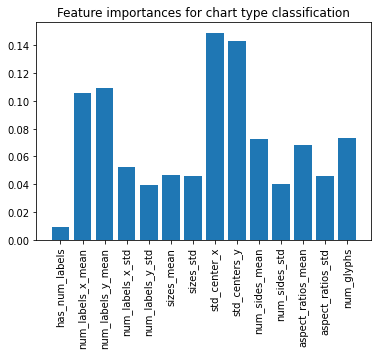

In [27]:
import matplotlib.pyplot as plt

plt.bar(X.columns, clf.feature_importances_, orientation='vertical')
plt.xticks(rotation = 90)
plt.title("Feature importances for chart type classification")
plt.show()